### Imports

In [2]:
import os
import cv2
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import List
from collections import namedtuple
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Normalize, Resize

### Labels

In [3]:
#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).

    'trainId'     , # An integer ID that overwrites the ID above, when creating ground truth
                    # images for training.
                    # For training, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for you approach.
# Note that you might want to ignore labels with ID 255 during training.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'ground'          , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'ground'          , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'ground'          , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'ground'          , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , 34 ,       19 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

# function to get the label from the name
def find_label(name):
    for label in labels:
        if label.name == name:
            return label.trainId, label.color
    return 255, (0,0,0)

### Loading Data

In [4]:
#For Working Within Kaggle - Seif
#--------------------------------------------------------------------------------
# train_images_folder = '/kaggle/input/cityscapes-segmentation/images/train'
# train_labels_folder = '/kaggle/input/cityscapes-segmentation/labels/train'

# training_csv_file_path = '/kaggle/working/cityscapes_training.csv'
# val_csv_file_path = '/kaggle/working/cityscapes_val.csv'
#--------------------------------------------------------------------------------

#For Working Locally - Youssif
#--------------------------------------------------------------------------------
# current_dir = os.path.dirname(os.getcwd())
train_images_folder = '/kaggle/input/images/train'
train_labels_folder = '/kaggle/input/labels/train'

# training_csv_file_path = os.path.join(current_dir, 'DataSet\\cityscapes_training.csv')
# val_csv_file_path = os.path.join(current_dir, 'DataSet\\cityscapes_val.csv')
#--------------------------------------------------------------------------------

data = {
    'image_path': [],
    'label_mask_path': [],
    'label_json_path': []
}
for city in os.listdir(train_images_folder):
    city_image_folder = os.path.join(train_images_folder, city)
    city_label_folder = os.path.join(train_labels_folder, city)
    # print(f"Processing {city} ...")
    
    if os.path.isdir(city_image_folder):
        for image_file in os.listdir(city_image_folder):
            # print(f"Processing {image_file} ...")
            if image_file.endswith('_leftImg8bit.png'):
                image_name_base = image_file.replace('_leftImg8bit.png', '')
                label_mask_file = f"{image_name_base}_gtFine_labelTrainIds.png"
                label_json_file = f"{image_name_base}_gtFine_polygons.json"
                
                data['image_path'].append(os.path.join(city_image_folder, image_file))
                data['label_mask_path'].append(os.path.join(city_label_folder, label_mask_file))
                data['label_json_path'].append(os.path.join(city_label_folder, label_json_file))
 
df = pd.DataFrame(data)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=23, shuffle=True)
# train_df.to_csv(training_csv_file_path, index=False)
# val_df.to_csv(val_csv_file_path, index=False)

In [5]:
#For Working Within Kaggle - Seif
#--------------------------------------------------------------------------------
test_images_folder = '/kaggle/input/images/test'

# test_csv_file_path = '/kaggle/working/cityscapes_test.csv'
#--------------------------------------------------------------------------------

#For Working Locally - Youssif
#--------------------------------------------------------------------------------
# test_images_folder = os.path.join(current_dir, 'DataSet\\Images\\Test_Set')

# test_csv_file_path = os.path.join(current_dir, 'DataSet\\cityscapes_test.csv')
#--------------------------------------------------------------------------------

test_data = {
    'image_path': []
}

for city in os.listdir(test_images_folder):
    city_image_folder = os.path.join(test_images_folder, city)
    
    if os.path.isdir(city_image_folder):
        for image_file in os.listdir(city_image_folder):
            if image_file.endswith('_leftImg8bit.png'):
                test_data['image_path'].append(os.path.join(city_image_folder, image_file))

test_df = pd.DataFrame(test_data)

# test_df.to_csv(test_csv_file_path, index=False)

### EDA

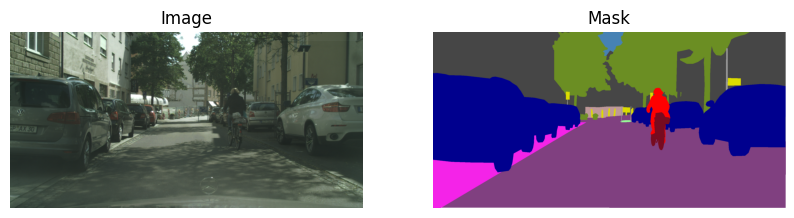

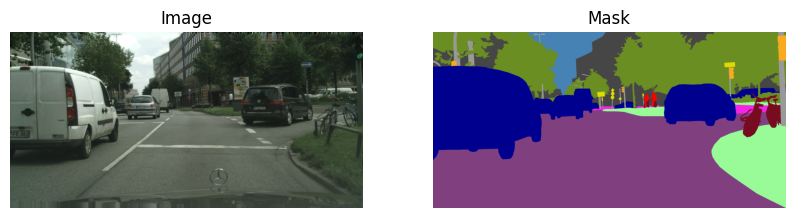

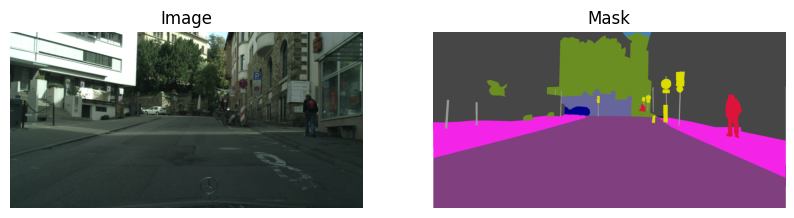

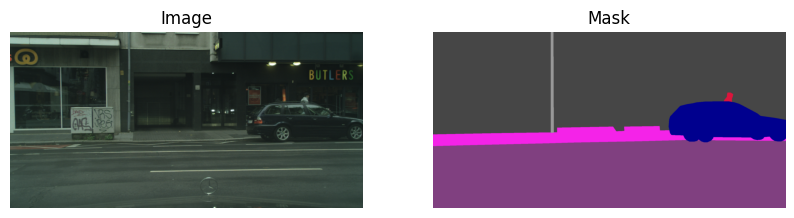

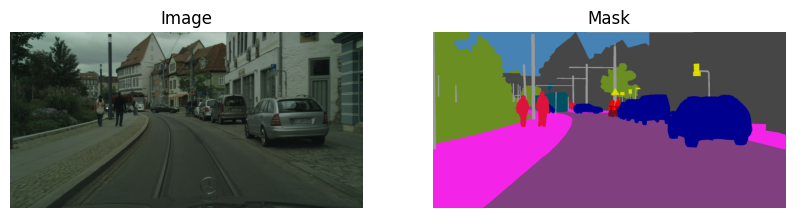

In [6]:
# Displaying A Sample of Images and Masks
def show_img_mask(row):
    image = cv2.cvtColor(cv2.imread(row['image_path']), cv2.COLOR_BGR2RGB)
    mask = cv2.imread(row['label_mask_path'])

    json_data = json.load(open(row['label_json_path']))

    for obj in json_data['objects']:
        label = obj['label']
        trainId, color = find_label(label)
        if trainId != 255:
            mask = cv2.fillPoly(mask, np.array([obj['polygon']], dtype=np.int32), color)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)
    ax[0].axis('off')
    ax[0].set_title('Image')
    ax[1].imshow(mask, cmap='gray')
    ax[1].axis('off')
    ax[1].set_title('Mask')
    plt.show()

rSample = train_df.sample(5)
for index, row in rSample.iterrows():
    show_img_mask(row)

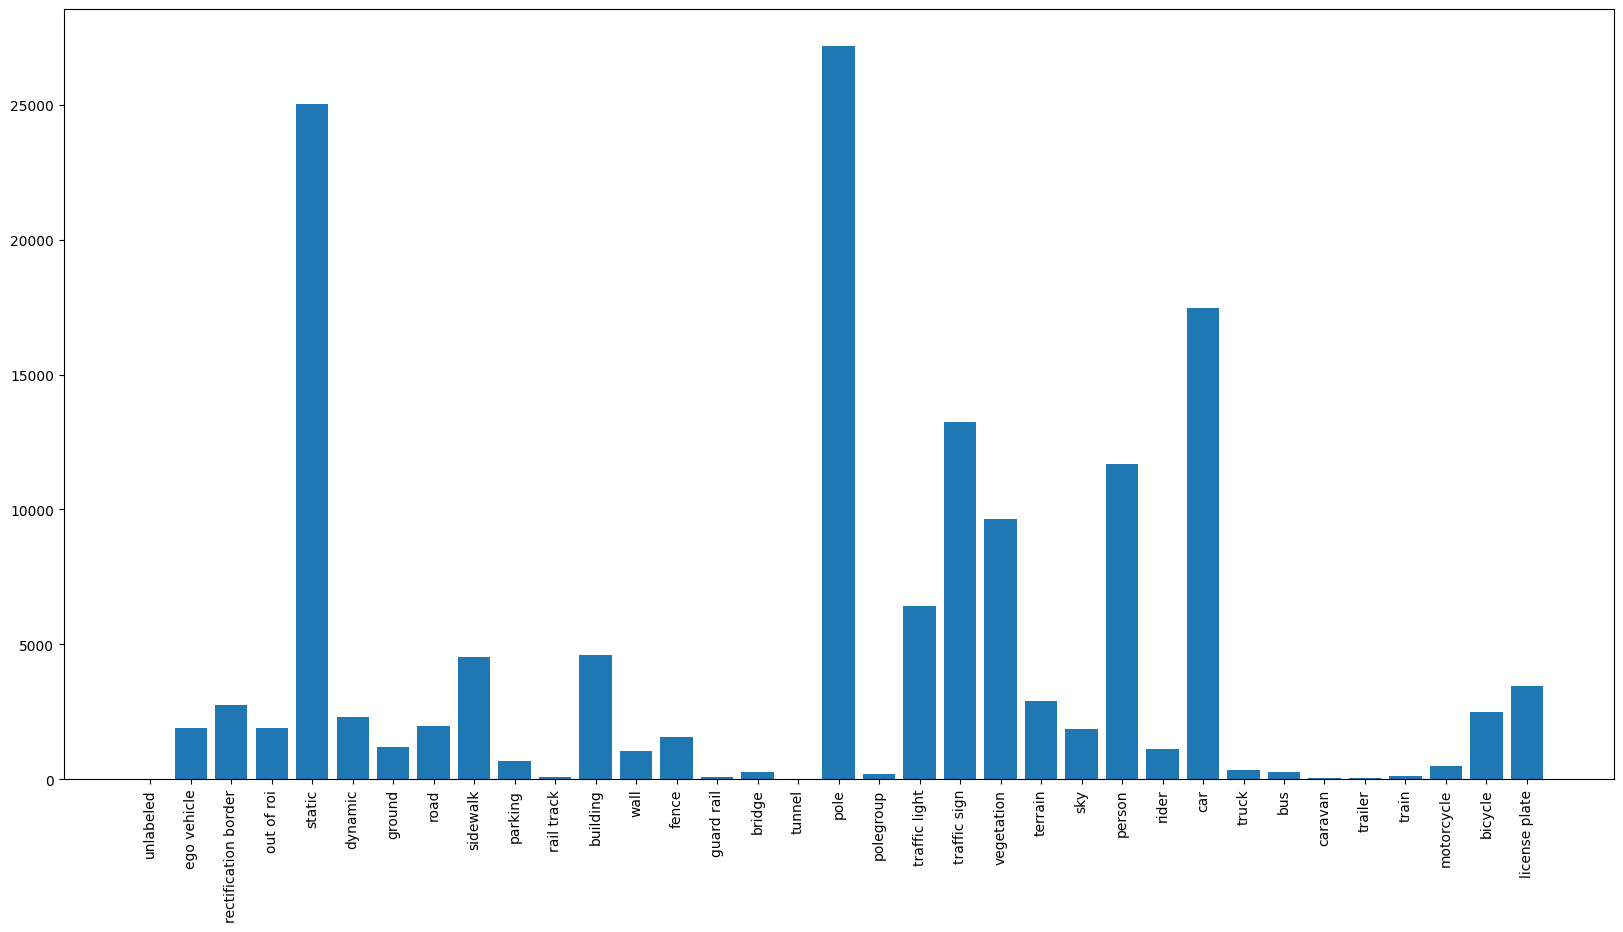

{'cargroup': 1209, 'bicyclegroup': 558, 'persongroup': 553, 'ridergroup': 9, 'motorcyclegroup': 7, 'truckgroup': 1}


In [7]:
# Analyzing the Distribution of the Labels accross the train Dataset
labels_freq = {label.name: 0 for label in labels}
labels_not_found = {}

dimensions_freq = {}

for index, row in train_df.iterrows():
    json_data = json.load(open(row['label_json_path']))
    
    dimensions = f"{json_data['imgWidth']}x{json_data['imgHeight']}"
    dimensions_freq[dimensions] = dimensions_freq.get(dimensions, 0) + 1

    for obj in json_data['objects']:
        label = obj['label']
        if label in labels_freq:
            labels_freq[label] += 1
        else:
            if label not in labels_not_found:
                labels_not_found[label] = 1
            else:
                labels_not_found[label] += 1
        
plt.figure(figsize=(20, 10))
plt.bar(labels_freq.keys(), labels_freq.values())
plt.xticks(rotation=90)
plt.show()
print(labels_not_found)

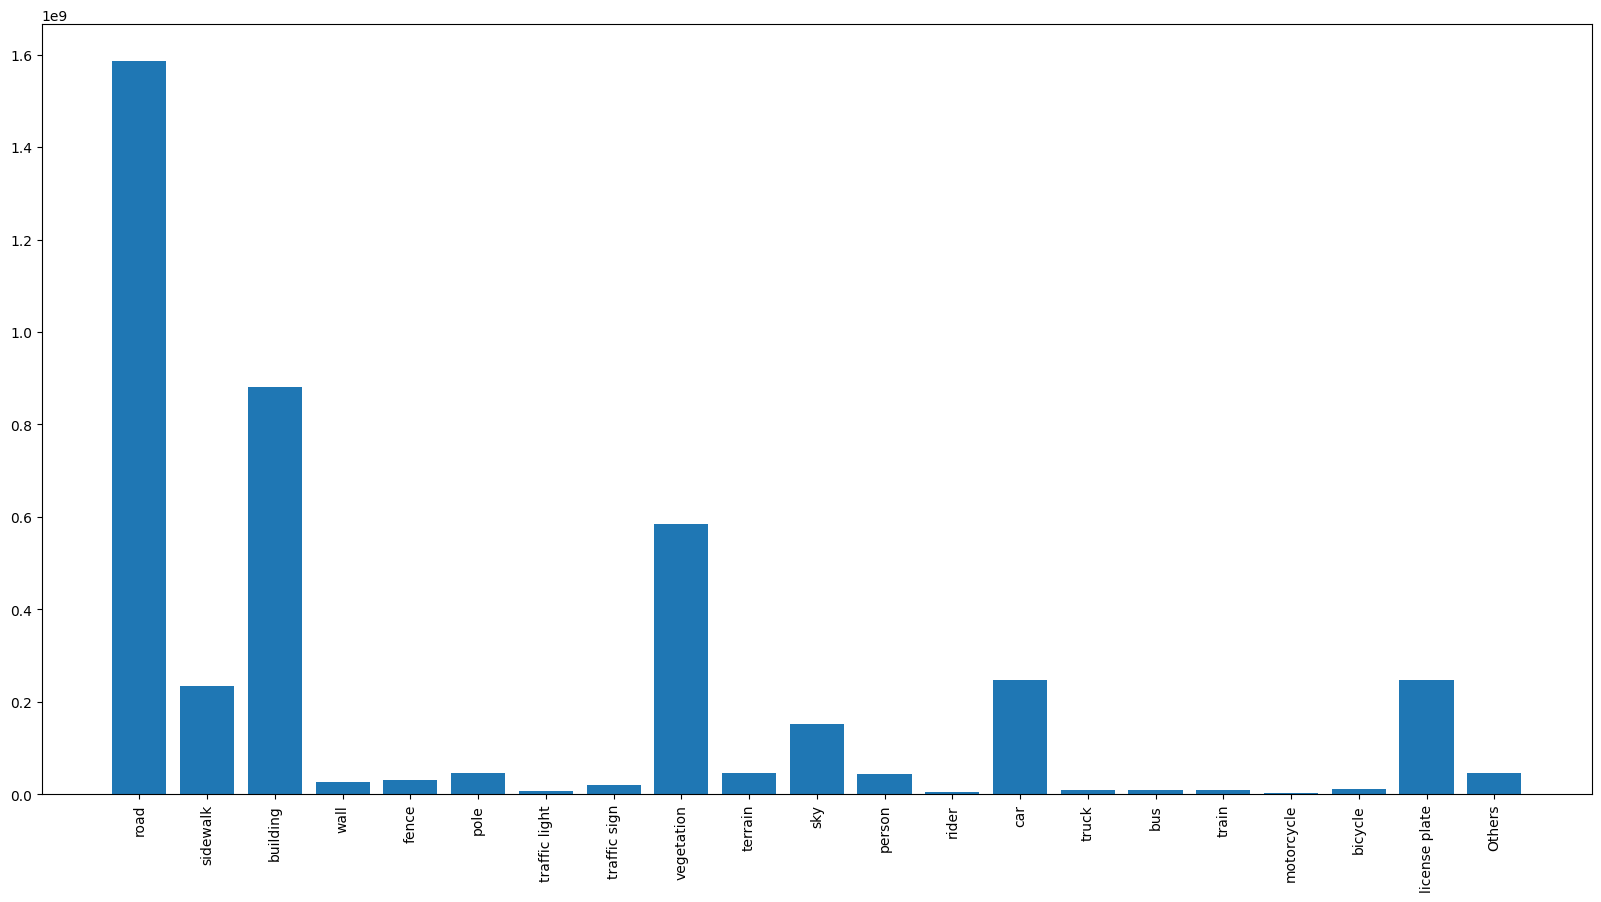

In [14]:
# Pixels Covered by Each Label
def get_labels_pixels(row):
    mask = cv2.imread(row['label_mask_path'])
    json_data = json.load(open(row['label_json_path']))

    for obj in json_data['objects']:
        label = obj['label']
        trainId, color = find_label(label)
        if trainId != 255:
            mask = cv2.fillPoly(mask, np.array([obj['polygon']], dtype=np.int32), color)

    return mask

train_df['label_mask'] = train_df.apply(get_labels_pixels, axis=1)

labels_pixels = {label.name: 0 for label in labels if label.trainId != 255}
labels_pixels['Others'] = 0

for index, row in train_df.iterrows():
    for label in labels:
        if label.trainId != 255:
            labels_pixels[label.name] += np.sum((row['label_mask'][:,:,0] == label.color[0]) &
                                                (row['label_mask'][:,:,1] == label.color[1]) &
                                                (row['label_mask'][:,:,2] == label.color[2]))
        else:
            labels_pixels['Others'] += np.sum((row['label_mask'][:,:,0] == label.color[0]) &
                                              (row['label_mask'][:,:,1] == label.color[1]) &
                                              (row['label_mask'][:,:,2] == label.color[2]))

plt.figure(figsize=(20, 10))
plt.bar(labels_pixels.keys(), labels_pixels.values())
plt.xticks(rotation=90)
plt.show()

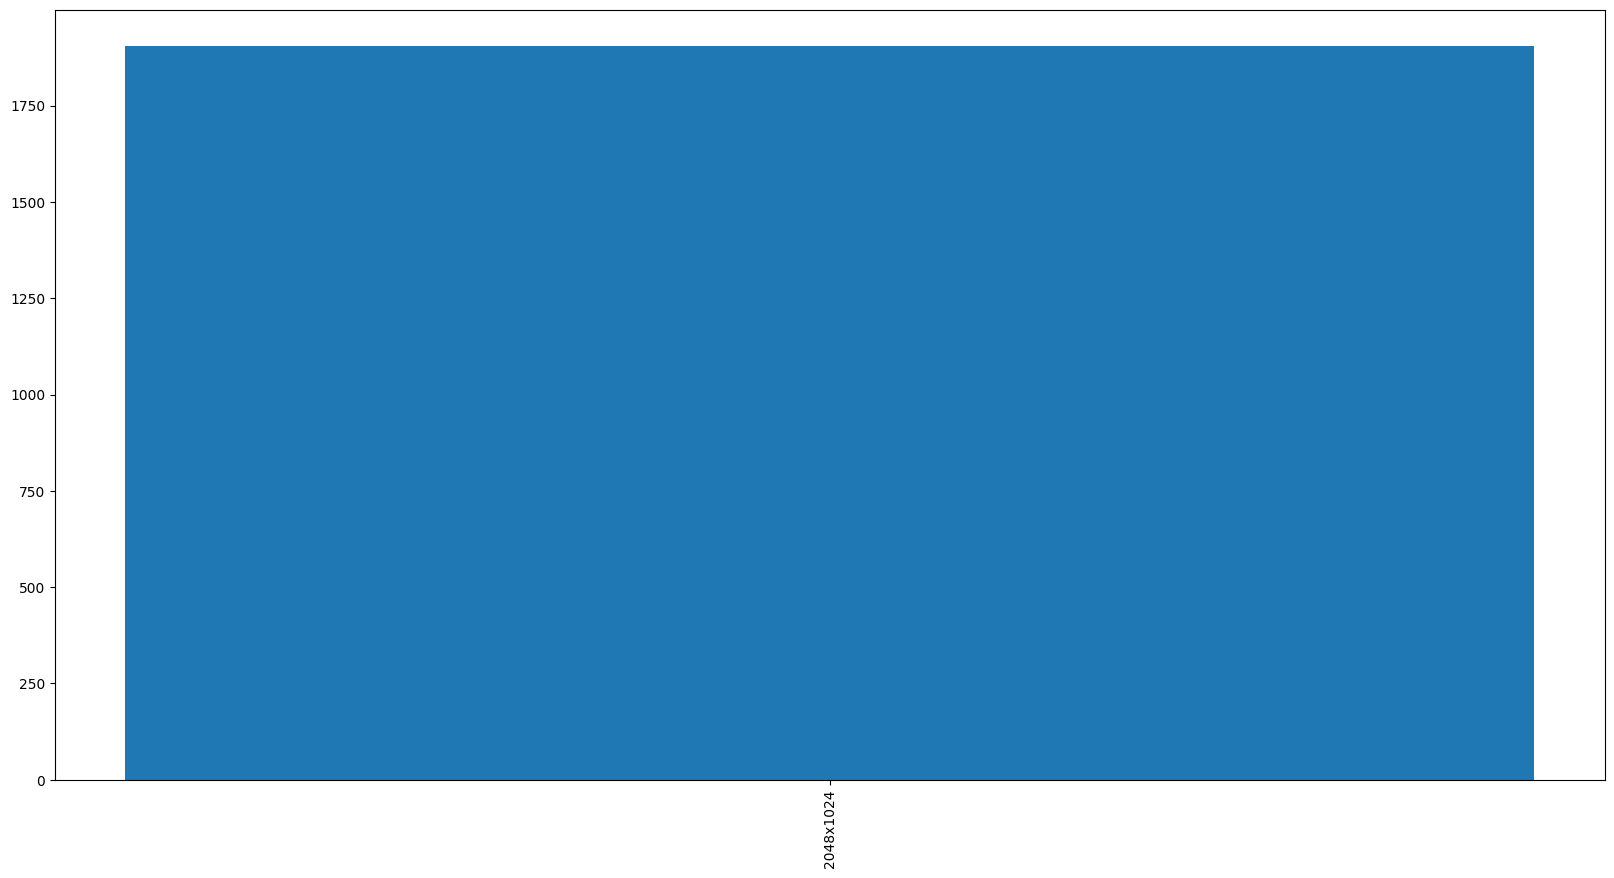

In [15]:
# Bar Plot for the Dimensions of the Images
plt.figure(figsize=(20, 10))
plt.bar(dimensions_freq.keys(), dimensions_freq.values())
plt.xticks(rotation=90)
plt.show()

# All Images have the same dimensions

### Augmentation

In [8]:
import os
import json

augmented_data={
    'image_path': [],
    'label_mask_path': [],
    'label_json_path': []
}

target_labels = {'bus', 'rider', 'truck', 'terrain', 'wall', 'building', 'road', 'motorcycle', 'bicycle','fence','license plate'}

image_paths_with_labels = []
i=0

for index, row in train_df.iterrows():
            json_data = json.load(open(row['label_json_path']))
            
#             has_target_label = any(obj['label'] in target_labels for obj in json_data['objects'])
            target_label_count = sum(1 for obj in json_data['objects'] if obj['label'] in target_labels)
            if target_label_count>12:
                augmented_data['image_path'].append(row['image_path'])
                augmented_data['label_mask_path'].append(row['label_mask_path'])
                augmented_data['label_json_path'].append(row['label_json_path'])
                

df_augmented=pd.DataFrame(augmented_data)
print(f'Found {len(df_augmented)} images containing the specified labels:')


Found 568 images containing the specified labels:


In [9]:
import os
import cv2
import pandas as pd
import torch
import albumentations as A
from albumentations.core.composition import OneOf
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.Resize(300, 300),  # Resize to (H, W)
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize pixel values
])
# Augmentation pipeline
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.RandomCrop(width=256, height=256, p=1.0),
    ToTensorV2()
])

def augment_image(image_path, mask_path):
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Ensure mask stays grayscale
    
    augmented = augmentation(image=image, mask=mask)
    aug_image = augmented['image'].permute(1, 2, 0).cpu().numpy()  # Convert tensor to NumPy array
    aug_mask = augmented['mask'].cpu().numpy()

    return aug_image, aug_mask


def generate_augmented_df(df, num_augments=1, output_dir='augmented_data'):
#     os.makedirs(output_dir, exist_ok=True)  # Create output directory if not exists
    ha=0
    augmented_data = []

    for index, row in df.iterrows():
        image_path = row['image_path']
        mask_path = row['label_mask_path']
        
        for i in range(num_augments):
            aug_image, aug_mask = augment_image(image_path, mask_path)
#             plt.figure(figsize=(10, 5))
#             plt.subplot(1, 2, 1)
#             plt.imshow(aug_image)
#             plt.title('Augmented Image')

#             plt.subplot(1, 2, 2)
#             plt.imshow(aug_mask, cmap='gray')
#             plt.title('Augmented Mask')
#             plt.show()

            transformed = transform(image=aug_image, mask=aug_mask)
            image = transformed['image']
            mask = transformed['mask']

            ha=ha+1
#             print(ha)
            augmented_data.append({
                'augmented_image': torch.tensor(image).permute(2, 0, 1),  # HWC -> CHW
                'augmented_mask': torch.tensor(mask)  # Mask as tensor
            })

    # Create DataFrame from augmented data
    augmented_df = pd.DataFrame(augmented_data)
    return augmented_df,ha


augmented_df ,h= generate_augmented_df(df_augmented, num_augments=5)
print(augmented_df,h)


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


                                        augmented_image  \
0     [[[tensor(-0.9020), tensor(-0.9705), tensor(-0...   
1     [[[tensor(-1.3987), tensor(-1.4158), tensor(-1...   
2     [[[tensor(-1.4672), tensor(-1.4500), tensor(-1...   
3     [[[tensor(-1.5185), tensor(-1.5528), tensor(-1...   
4     [[[tensor(-1.7754), tensor(-1.7754), tensor(-1...   
...                                                 ...   
2835  [[[tensor(-0.6965), tensor(-0.7137), tensor(-0...   
2836  [[[tensor(-0.5082), tensor(-0.5596), tensor(-0...   
2837  [[[tensor(0.3823), tensor(0.3994), tensor(0.39...   
2838  [[[tensor(-0.4911), tensor(-0.5082), tensor(-0...   
2839  [[[tensor(-1.4158), tensor(-1.4329), tensor(-1...   

                                         augmented_mask  
0     [[tensor(8, dtype=torch.uint8), tensor(8, dtyp...  
1     [[tensor(8, dtype=torch.uint8), tensor(8, dtyp...  
2     [[tensor(9, dtype=torch.uint8), tensor(9, dtyp...  
3     [[tensor(8, dtype=torch.uint8), tensor(8, dtyp...  
4

                                        image_tensor  \
0  [[[tensor(-1.2274), tensor(-1.4500), tensor(-1...   
1  [[[tensor(-0.4054), tensor(-0.2342), tensor(-0...   
2  [[[tensor(-0.9534), tensor(-0.9363), tensor(-0...   
3  [[[tensor(-1.4500), tensor(-1.4843), tensor(-1...   
4  [[[tensor(-2.1179), tensor(-1.3473), tensor(-1...   

                                         mask_tensor  
0  [[[tensor(255, dtype=torch.uint8), tensor(255,...  
1  [[[tensor(255, dtype=torch.uint8), tensor(255,...  
2  [[[tensor(255, dtype=torch.uint8), tensor(255,...  
3  [[[tensor(255, dtype=torch.uint8), tensor(255,...  
4  [[[tensor(255, dtype=torch.uint8), tensor(255,...  


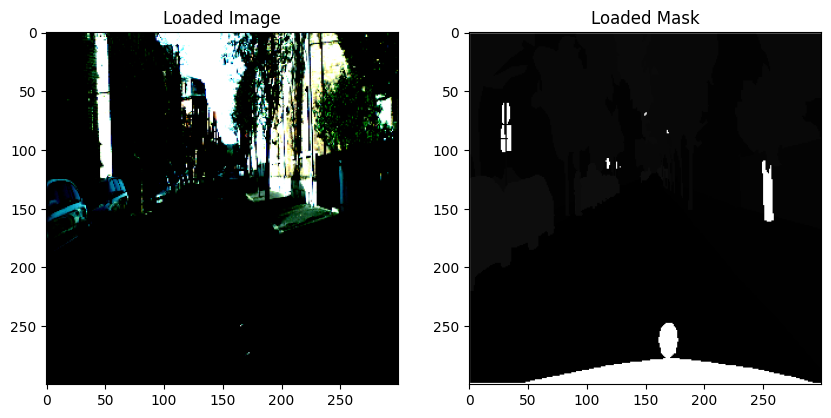

In [10]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import torch

def load_image_and_mask(image_path, mask_path):
    image = cv2.imread(image_path)  # BGR format
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Grayscale mask
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    transformed = transform(image=image, mask=mask)
    image = transformed['image']
    mask = transformed['mask']
    
    image_tensor = torch.tensor(image).permute(2, 0, 1)  # (H, W, C) -> (C, H, W)
    mask_tensor = torch.tensor(mask).unsqueeze(0)  # Add channel dim: (H, W) -> (1, H, W)

    return image_tensor, mask_tensor

def create_image_dataframe(df):
    data = []

    for index, row in df.iterrows():
        image_path = row['image_path']
        mask_path = row['label_mask_path']

        image_tensor, mask_tensor = load_image_and_mask(image_path, mask_path)
        
        data.append({
            'image_tensor': image_tensor,  # Image tensor
            'mask_tensor': mask_tensor     # Mask tensor
        })

    # Create a DataFrame with the loaded data
    image_df = pd.DataFrame(data)
    return image_df

# Example usage with train_df
loaded_train_df = create_image_dataframe(train_df)

# Display the first few rows of the DataFrame
print(loaded_train_df.head())

# Example: Visualize a loaded image and mask from the DataFrame
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(loaded_train_df.iloc[0]['image_tensor'].permute(1, 2, 0).numpy())  # CHW -> HWC
plt.title('Loaded Image')

plt.subplot(1, 2, 2)
plt.imshow(loaded_train_df.iloc[0]['mask_tensor'].squeeze(0).numpy(), cmap='gray')  # Remove channel dim
plt.title('Loaded Mask')

plt.show()


In [40]:
print(loaded_train_df)

                                           image_tensor  \
0     [[[tensor(-1.2274), tensor(-1.4500), tensor(-1...   
1     [[[tensor(-0.4054), tensor(-0.2342), tensor(-0...   
2     [[[tensor(-0.9534), tensor(-0.9363), tensor(-0...   
3     [[[tensor(-1.4500), tensor(-1.4843), tensor(-1...   
4     [[[tensor(-2.1179), tensor(-1.3473), tensor(-1...   
...                                                 ...   
1899  [[[tensor(-0.5082), tensor(1.7009), tensor(2.2...   
1900  [[[tensor(-1.5185), tensor(-1.2617), tensor(-1...   
1901  [[[tensor(-1.4843), tensor(-1.3644), tensor(-1...   
1902  [[[tensor(-1.2788), tensor(-0.8849), tensor(-1...   
1903  [[[tensor(-1.9124), tensor(-1.8268), tensor(-1...   

                                            mask_tensor  
0     [[[tensor(255, dtype=torch.uint8), tensor(255,...  
1     [[[tensor(255, dtype=torch.uint8), tensor(255,...  
2     [[[tensor(255, dtype=torch.uint8), tensor(255,...  
3     [[[tensor(255, dtype=torch.uint8), tensor(255,...  
4

an error occure in the next cell that there is no memory

In [ ]:
import pandas as pd
import torch

def load_data_in_batches(train_df, augmented_df, batch_size=32):
    for i in range(0, len(train_df), batch_size):
        train_images = train_df['image_tensor'].iloc[i:i + batch_size].tolist()
        train_masks = train_df['mask_tensor'].iloc[i:i + batch_size].tolist()
        
        augmented_images = augmented_df['augmented_image'].tolist()
        augmented_masks = augmented_df['augmented_mask'].tolist()
        
        combined_images = train_images + augmented_images
        combined_masks = train_masks + augmented_masks

        yield combined_images, combined_masks

# Create a new DataFrame and load in batches
new_df_list = []

for images, masks in load_data_in_batches(loaded_train_df, augmented_df, batch_size=32):
    new_df_list.append(pd.DataFrame({
        'image_tensor': images,
        'mask_tensor': masks
    }))

# Concatenate all DataFrames
new_df = pd.concat(new_df_list, ignore_index=True)

# Display the resulting DataFrame
print(new_df)


### PreProcessing & The rest

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device) #4744

Using device: cuda


In [15]:
#TODO : Write the model you are going to use (Pytorch)

In [16]:
#TODO : Write the loss function you are going to use

In [17]:
#TODO : Write the evaluation metrics you are going to use

In [18]:
#TODO : Write your own Training loop using pytorch

In [19]:
#TODO : Plot losses and metrics graphs

In [20]:
#TODO : Test your model and show some samples